In [1]:
# If packages are require to install then uncomment below and install it.
# pip install yfinance pandas matplotlib seaborn cvxpy numpy

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import numpy as np

In [3]:
# Technology, Healthcare and Financial Service Industry assets by Capitals.
# Apple Inc. (AAPL) 
# Meta Platforms, Inc. (META)
# NVIDIA Corporation (NVDA)
# Alphabet Inc. (GOOGL)
# Microsoft Corporation (MSFT)
# Johnson & Johnson (JNJ)
# Pfizer Inc. (PFE)
# UnitedHealth Group Incorporated (UNH)
# Merck & Co., Inc. (MRK)
# AbbVie Inc. (ABBV)
# JPMorgan Chase & Co. (JPM)
# Bank of America Corporation (BAC)
# Wells Fargo & Company (WFC)
# Goldman Sachs Group, Inc. (GS)
# Morgan Stanley (MS)

In [4]:
tickers = ['AAPL', 'META', 'NVDA', 'GOOGL', 'MSFT', 'JNJ', 'PFE', 'MRK', 'ABBV', 'UNH', 'JPM', 'BAC', 'WFC', 'GS', 'MS']

[*********************100%%**********************]  15 of 15 completed


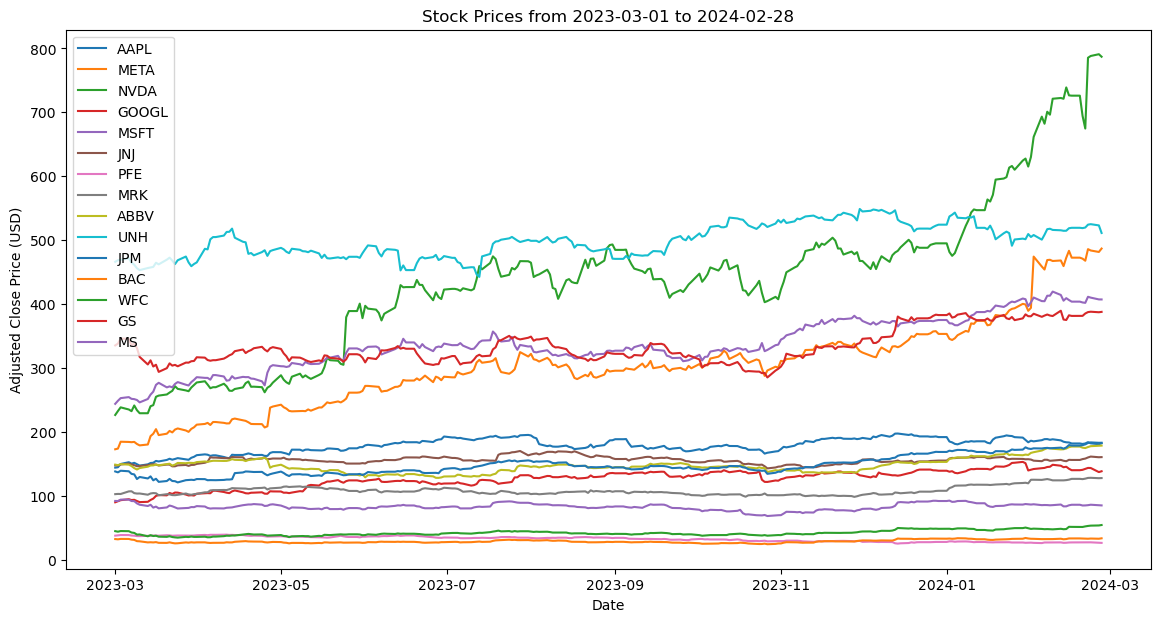

In [5]:
# define the date range
start_date = '2023-03-01'
end_date = '2024-02-28' 

# Fetch data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Only business days are used for returns calculation
data = data['Adj Close'].asfreq('B').ffill()

# Plot the adjusted close prices
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data[ticker], label=ticker)

plt.title('Stock Prices from {} to {}'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()


   Assets  Mean Return  Volatility
0    AAPL     0.277863    0.188076
1    META     0.214598    0.186713
2    NVDA     0.071834    0.267482
3   GOOGL     0.576825    0.272594
4    MSFT     0.180758    0.223845
5     JNJ     0.098123    0.155098
6     PFE     0.339525    0.198084
7     MRK     1.913803    0.367173
8    ABBV     0.255995    0.178144
9     UNH    -0.043549    0.251709
10    JPM     0.686191    0.222917
11    BAC     2.700409    0.457161
12    WFC    -0.271734    0.222909
13     GS     0.116618    0.203231
14     MS     0.253930    0.281661


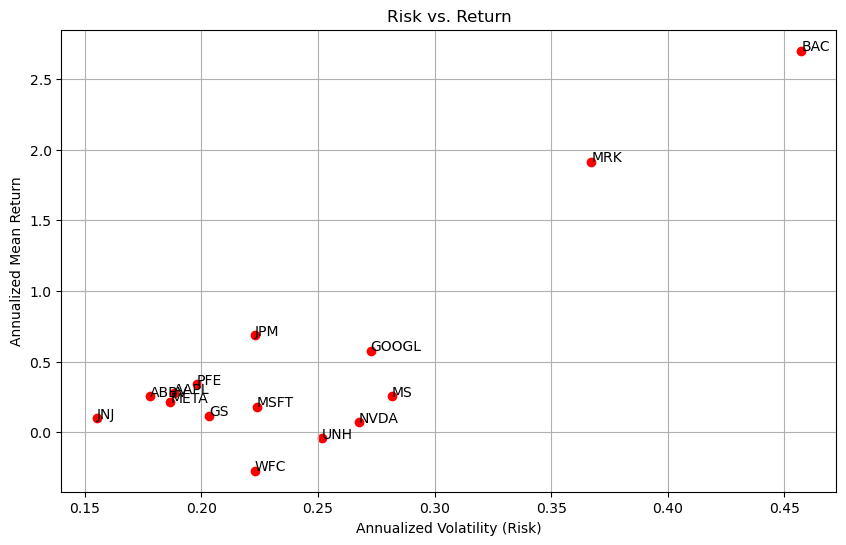

In [6]:
# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate mean return (annualized)
mean_return_daily = daily_returns.mean()
# Calculate the compounded annual growth rate (CAGR)
mean_return_annualized = ((1 + mean_return_daily) ** 252) - 1  

# Calculate volatility (standard deviation)
volatility_daily = daily_returns.std()
# Calculate annualized volatility
volatility_annualized = volatility_daily * (252 ** 0.5)


# output
results_df = pd.DataFrame({
    'Assets': tickers,
    'Mean Return': mean_return_annualized.values,
    'Volatility': volatility_annualized.values
})

print(results_df)


# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Volatility'], results_df['Mean Return'], color='red')

# Label each point with its asset ticker
for i, txt in enumerate(results_df['Assets']):
    plt.annotate(txt, (results_df['Volatility'][i], results_df['Mean Return'][i]))

# Title and labels
plt.title('Risk vs. Return')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Mean Return')
plt.grid(True)

# Show the plot
plt.show()

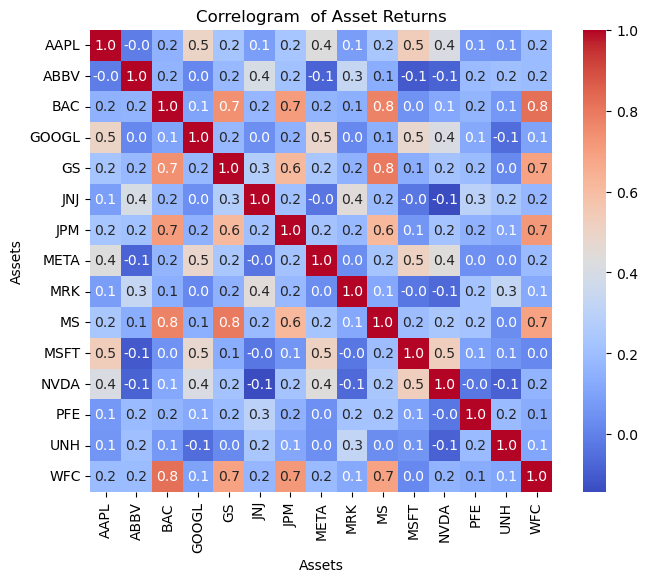

In [7]:

# Calculate the correlation matrix of daily returns
correlation_matrix = daily_returns.corr()

###### Calculate the covariance matrix of daily returns
covariance_matrix = daily_returns.cov()
#print(covariance_matrix)

# Rename the index and column names
correlation_matrix.index.names = ['Assets']
correlation_matrix.columns.names = ['Assets']

# Create the correlogram using seaborn
plt.figure(figsize=(8, 6))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm', square=True)
plt.title('Correlogram  of Asset Returns')
plt.show()


In [8]:

# Initialization
np.random.seed(0)
num_assets = 15
max_weight = 0.20  # Maximum weight of 20% for any asset
alpha = 0.05  # Risk tolerance level (95% confidence)

mean_returns = np.array(mean_return_annualized.values)
cov_matrix = np.array(covariance_matrix.values)  

# Define decision variables
weights = cp.Variable(num_assets)

# Define expected return
expected_return = mean_returns @ weights

# Define the portfolio standard deviation (for risk)
portfolio_std_dev = cp.quad_form(weights, cov_matrix)
VaR = cp.Variable() # Create a variable for the VaR
portfolio_losses = -expected_return # Calculate the portfolio losses (negative returns)
cvar = cp.Variable() #average losses beyond the VaR

# Constraint for the VaR (normal distribution of returns)
VaR_constraint = portfolio_std_dev <= VaR

# Constraint for the CVaR: the average value of the losses that exceed the VaR
cvar_constraint = cp.sum(cp.pos(portfolio_losses - VaR)) / (num_assets * alpha) <= cvar

# Define optimization constraints, including the CVaR constraint
constraints = [
    cp.sum(weights) == 1,  # Allocated the portfolio weight constraint
    weights >= 0,          # Non-negativity constraint
    weights <= max_weight, # Diversification constraint
    VaR_constraint,        # VaR should not exceed the standard deviation 
    cvar_constraint        # CVaR constraint
]

# Define the objective function
objective = cp.Maximize(expected_return)

# Define and solve the optimization problem using the ECOS solver
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS)

# Extract optimal solution
optimal_weights = weights.value
optimal_VaR = VaR.value
optimal_CVaR = cvar.value

# Print optimal portfolio return and VaR and CVaR
#print(f"Optimal Portfolio Expected Return: {expected_return.value * 100:.2f}%")
#print(f"Value at Risk (VaR): {optimal_VaR:.2f}")
print(f"Conditional Value at Risk (CVaR): {optimal_CVaR:.2f}")


Conditional Value at Risk (CVaR): 0.52


    Asset Optimal Weight Mean Return Volatility
0    AAPL         0.0000       27.79      18.81
1    META         0.0000       21.46      18.67
2    NVDA         0.0000        7.18      26.75
3   GOOGL         0.2000       57.68      27.26
4    MSFT         0.0000       18.08      22.38
5     JNJ         0.0000        9.81      15.51
6     PFE         0.2000       33.95      19.81
7     MRK         0.2000      191.38      36.72
8    ABBV         0.0000       25.60      17.81
9     UNH        -0.0000       -4.35      25.17
10    JPM         0.2000       68.62      22.29
11    BAC         0.2000      270.04      45.72
12    WFC        -0.0000      -27.17      22.29
13     GS         0.0000       11.66      20.32
14     MS         0.0000       25.39      28.17


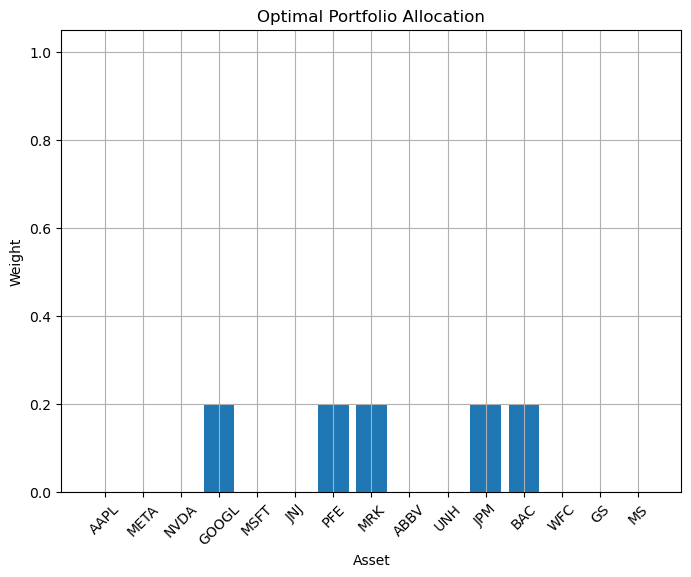

In [9]:
annualized_volatility = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)  #  252 business days of trading days in a year

# the asset-specific details
asset_details = pd.DataFrame({
    'Asset': results_df['Assets'],  # asset names
    'Optimal Weight': optimal_weights,
    'Mean Return': mean_returns * 100,  # to percentage
    'Volatility': annualized_volatility * 100  # to percentage
})

# formatting column 
asset_details['Optimal Weight'] = asset_details['Optimal Weight'].apply(lambda x: '{:.4f}'.format(x))
asset_details['Mean Return'] = asset_details['Mean Return'].apply(lambda x: '{:.2f}'.format(x))
asset_details['Volatility'] = asset_details['Volatility'].apply(lambda x: '{:.2f}'.format(x))

# Display the asset-specific table
print(asset_details)


# Plot optimal portfolio allocation
plt.figure(figsize=(8, 6))
plt.bar(results_df['Assets'], optimal_weights)
plt.title('Optimal Portfolio Allocation')
plt.xlabel('Asset')
plt.ylabel('Weight')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylim(0, 1.05)  # Set y-axis limits to ensure all weights are displayed
plt.grid(True)
plt.show()
